In [1]:
from optionCombo import optionModel,preInit

C:\Users\5565\AppData\Local\Programs\Python\Python310\lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


# Collect Deribit option data

In [2]:
import requests
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from datetime import datetime
import random
import time
from tqdm.notebook import tqdm
#most of the code comes from this repo https://github.com/schepal/deribit_data_collector/blob/master/deribit_data.py

def request_get(url):
    while True:
        try:
            page = requests.get(url)
            return page.json()['result']
        except:time.sleep(random.randint(1,5))
        
def get_options_list():
    data = {'currency': currency, 'kind': 'option'}
    r = requests.get(url + 'get_instruments', data)
    df = pd.DataFrame(r.json()['result'])
    cols = ['expiration_timestamp', 'option_type', 'instrument_name', 'strike']
    return df[cols]
def get_option_urls():
    url_storage = []
    options_list = get_options_list()
    request_url = url + 'get_order_book?instrument_name='
    for option in range(len(options_list)):
        data = request_url + options_list.instrument_name.values[option]
        url_storage.append(data)
    return url_storage
def collect_clean_data():

    raw_data = []
    pool = ThreadPoolExecutor(max_workers=10)
    print("Collecting data...")
    urls = get_option_urls()
    for asset in tqdm(pool.map(request_get,urls ),total=len(urls)):
        raw_data.append(asset)
    data = pd.DataFrame(raw_data)

    option_data = data
    option_data['infos'] = option_data['instrument_name'].apply(lambda x: x.split('-'))
    option_data['expiration'] = option_data['infos'].apply(
        lambda x: pd.to_datetime(x[1]))  # pd.to_datetime(option_data['expiration'])#
    option_data['is_call'] = option_data['infos'].apply(lambda x: x[-1])
    option_data['K'] = option_data['infos'].apply(lambda x: x[-2])
    option_data['ticker'] = option_data['infos'].apply(lambda x: x[0])
    option_data['askIv'] = option_data['ask_iv'] / 100  # option_data['askIV']#
    option_data['bidIv'] = option_data['bid_iv'] / 100  # option_data['bidIV']#
    option_data[['K', 'bidIV', 'askIV']] = option_data[['K', 'bidIv', 'askIv']].astype('float')

    option_data['expiry'] = option_data['expiration'].apply(lambda x: (pd.to_datetime(x) - datetime.now()) / (pd.to_timedelta('365d')))

    option_data = option_data[['is_call','K','askIV','bidIV','expiry','expiration']]
    expirList = option_data.sort_values(by=['expiration'])['expiration'].unique()


    return option_data,expirList

In [3]:
global currency
global url
currency = 'BTC'
url = 'https://www.deribit.com/api/v2/public/'
option_data,expirList = collect_clean_data()

  0%|          | 0/722 [00:00<?, ?it/s]

In [4]:
expirList

<DatetimeArray>
['2023-06-19 00:00:00', '2023-06-20 00:00:00', '2023-06-21 00:00:00',
 '2023-06-23 00:00:00', '2023-06-30 00:00:00', '2023-07-07 00:00:00',
 '2023-07-28 00:00:00', '2023-08-25 00:00:00', '2023-09-29 00:00:00',
 '2023-12-29 00:00:00', '2024-03-29 00:00:00']
Length: 11, dtype: datetime64[ns]

In [5]:
# choose a expiry date, doesn't support mutiple expiry dates at the moment
expirDate = '2023-07-28T00:00:00.000000000'

In [6]:
# this is what the option Dataframe should look like 
option_data

,is_call,K,askIV,bidIV,expiry,expiration
0,C,22500.0,0.0000,0.0000,-0.001322,2023-06-19
1,P,22500.0,3.4328,0.0000,-0.001322,2023-06-19
2,C,23000.0,0.0000,0.0000,-0.001322,2023-06-19
3,P,23000.0,3.0240,0.0000,-0.001322,2023-06-19
4,C,23500.0,0.0000,0.0000,-0.001322,2023-06-19
...,...,...,...,...,...,...
717,P,90000.0,0.0000,0.0000,0.776761,2024-03-29
718,C,100000.0,0.7124,0.6909,0.776761,2024-03-29
719,P,100000.0,0.0000,0.0000,0.776761,2024-03-29
720,C,120000.0,0.7559,0.7167,0.776761,2024-03-29


# Collect price data, this is used for determine asset price range

In [7]:
import ccxt
def fetchprice(symbol,exchange = 'binance'):
    res = {}
    exchange = getattr(ccxt, exchange)()


    while True:
        try:
            data = exchange.fetch_ohlcv(symbol, '15m', None, 1000)
            header = ["Timestamp", "open", "high", "low", "close", "volume"]
            df = pd.DataFrame(data, columns=header)
            df = df[["Timestamp", "open", "high", "low", "close", "volume"]]
            break
        except Exception as e:
            print(e)
            time.sleep(1)
    for i in range(20):
        while True:
            try:
                since = df.Timestamp.values[0] - 1000*15*60*1000
                data = exchange.fetch_ohlcv(symbol, '15m', since, 1000)
                header = ["Timestamp", "open", "high", "low", "close", "volume"]
                df1 = pd.DataFrame(data, columns=header)
                df1 = df1[["Timestamp", "open", "high", "low", "close", "volume"]]
                df = pd.concat([df1,df]).reset_index(drop=True)
                break
            except Exception as e:
                print(e)
                time.sleep(1)
    df = df[["Timestamp", "open", "high", "low", "close", "volume"]]
    df['Timestamp'] = pd.to_datetime(df['Timestamp'] / 1000, unit="s")
    df["open"] = pd.to_numeric(df["open"])
    df["high"] = pd.to_numeric(df["high"])
    df["low"] = pd.to_numeric(df["low"])
    df["close"] = pd.to_numeric(df["close"])
    df["volume"] = pd.to_numeric(df["volume"])
    return df

In [8]:
pricedata = fetchprice('BTCUSDT')

In [9]:
# this is what the price Dataframe should look like 
pricedata

,Timestamp,open,high,low,close,volume
0,2022-11-12 09:45:00,16897.77,16905.22,16812.21,16863.98,2367.18194
1,2022-11-12 10:00:00,16864.46,16879.00,16817.84,16877.38,2019.13660
2,2022-11-12 10:15:00,16877.38,16977.45,16857.08,16900.45,3101.28490
3,2022-11-12 10:30:00,16900.28,16944.44,16862.43,16872.18,2080.01205
4,2022-11-12 10:45:00,16874.24,16896.37,16807.13,16843.88,2186.38323
...,...,...,...,...,...,...
20995,2023-06-19 02:30:00,26422.61,26450.00,26422.60,26449.42,109.73857
20996,2023-06-19 02:45:00,26449.42,26457.71,26432.25,26446.33,72.58563
20997,2023-06-19 03:00:00,26446.33,26453.94,26420.00,26436.00,147.88477
20998,2023-06-19 03:15:00,26435.99,26436.00,26406.00,26406.00,83.03010


In [10]:
# this part of the code is for pre-compute

preOption,strikePrices,price = preInit.Prep( expirDate, optionDf = option_data, priceDf = pricedata, interval=3, strikePriceRange=0.2)

C:\Users\5565\AppData\Local\Programs\Python\Python310\lib\site-packages\optionCombo\preInit.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  option_data['per_ivs'] = option_data['bidIV'].apply(lambda x: list(np.linspace(1 * lowerIV, 1 * upperIV, 89)), 0)


In [11]:
# this part of the code is for loop through all the possible option combination of 4 call options, 1 stands for call option
# -1 stands for put options, possible input for "optionstypes" should be a two dimension list, eg. [[1,1,1],[-1,-1,1,1]]
# maxquantity is the input for the maximum potential quantity of a single option trade amount

model = optionModel.option_model(price, strikePrices,preOption,optionstypes = [[1,1,1,1],[1,1],[-1,-1,1,1]], maxquantity=3)  # Init

df = model.options_model_finder()                                                                           # start looping

100%|███████████████████████████████████████████████████████████████████████████| 27428/27428 [03:48<00:00, 120.02it/s]


In [13]:
# output contains all the possible combinations given the parameters, you can filter out the result as you want
df

,para,stra,loss,probal,RR,wv,wp,bv,bp,delta_starting,mean_delta,std_delta,mean_vega,mean_theta,std_theta,premium
0,"[26410.01, [0.10552773815525114, 0.10552773815...",C_25000_1__C_26000_1__C_27000_1__C_28000_1,1.000000,0.640449,11.321502,0.85,18695.814118,0.85,44841.770944,2.087200,2.804247,1.438611,47.620628,-29.920055,24.632729,5954.394675
1,"[26410.01, [0.10552773815525114, 0.10552773815...",C_25000_1__C_26000_1__C_28000_1__C_29000_1,1.000000,0.640449,12.259549,0.85,18695.814118,0.85,44841.770944,1.898408,2.728865,1.447447,50.134162,-31.559090,24.333957,5382.316137
2,"[26410.01, [0.10552773815525114, 0.10552773815...",C_25000_1__C_26000_1__C_27000_1__C_28000_2,1.000000,0.640449,12.319576,0.85,18695.814118,0.85,44841.770944,2.449842,3.448976,1.821887,60.751175,-37.938906,30.993967,6772.651992
3,"[26410.01, [0.10552773815525114, 0.10552773815...",C_25000_1__C_26000_1__C_28000_1__C_29000_2,1.000000,0.629213,13.614885,0.85,18695.814118,0.85,44841.770944,2.175817,3.335900,1.834357,64.642103,-40.522061,30.893446,5967.125776
4,"[26410.01, [0.10552773815525114, 0.10552773815...",C_25000_1__C_26000_1__C_27000_1__C_28000_3,1.000000,0.629213,13.102477,0.85,18695.814118,0.85,44841.770944,2.812483,4.093705,2.206110,73.881723,-45.957756,37.506506,7590.909308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27423,"[26410.01, [0.10552773815525114, 0.10552773815...",P_24000_-4__P_25000_-4__C_27000_-4__C_28000_-3,9.117038,0.235955,0.109685,0.85,44841.770944,0.85,25232.303325,0.793776,5.562820,5.176368,-167.166642,94.002564,84.475823,12048.229155
27424,"[26410.01, [0.10552773815525114, 0.10552773815...",P_24000_-4__P_25000_-4__C_28000_-4__C_29000_-3,10.494873,0.247191,0.095285,0.85,44841.770944,0.85,25232.303325,0.111141,5.438711,5.199818,-175.571113,99.283368,81.738564,9995.099213
27425,"[26410.01, [0.10552773815525114, 0.10552773815...",P_24000_-4__P_26000_-4__C_27000_-4__C_29000_-3,8.254646,0.247191,0.121144,0.85,44841.770944,0.85,26123.642762,0.100637,5.523449,5.278394,-173.371070,96.857070,83.997490,12846.779664
27426,"[26410.01, [0.10552773815525114, 0.10552773815...",P_25000_-4__P_26000_-4__C_27000_-4__C_28000_-3,7.369587,0.224719,0.135693,0.85,44841.770944,0.85,26123.642762,0.005537,5.652492,5.423375,-171.217803,93.875648,88.602371,14563.729062


In [14]:
temp = df.loc[  (df['probal']>0.5)&(df['mean_theta']>0)].sort_values(by=['mean_vega','probal'], ascending=[False,False])
temp

,para,stra,loss,probal,RR,wv,wp,bv,bp,delta_starting,mean_delta,std_delta,mean_vega,mean_theta,std_theta,premium
23377,"[26410.01, [0.10552773815525114, 0.10552773815...",P_25000_-3__P_26000_3__C_28000_2__C_29000_-2,1.000000,0.865169,0.704804,0.85,26123.642762,0.85,18695.814118,0.145794,0.068259,0.091215,0.501712,0.041537,4.471890,8620.737799
20768,"[26410.01, [0.10552773815525114, 0.10552773815...",P_24000_-2__P_25000_2__C_27000_1__C_28000_-1,1.000000,0.865169,1.160628,0.85,25232.303325,0.85,18695.814118,0.075723,0.047121,0.066561,0.470079,0.120619,2.842410,4575.924734
20770,"[26410.01, [0.10552773815525114, 0.10552773815...",P_24000_-2__P_26000_2__C_27000_1__C_29000_-1,1.000000,0.853933,1.068162,0.85,26123.642762,0.85,18695.814118,0.201607,0.097643,0.132877,0.469447,0.687450,5.476555,5117.985789
26162,"[26410.01, [0.10552773815525114, 0.10552773815...",P_25000_-4__P_26000_4__C_28000_3__C_29000_-3,1.000000,0.865169,0.644256,0.85,26123.642762,0.85,18695.814118,0.164237,0.091264,0.120851,0.313832,0.257637,6.108896,11953.421100
23095,"[26410.01, [0.10552773815525114, 0.10552773815...",P_24000_-3__P_26000_2__C_27000_3__C_29000_-2,1.411109,0.685393,4.170496,0.85,18695.814118,0.85,44841.770944,0.681848,0.890836,0.217350,0.302175,0.011178,8.953931,8507.264791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27286,"[26410.01, [0.10552773815525114, 0.10552773815...",P_25000_-4__P_26000_-4__C_27000_3__C_28000_-4,6.393072,0.528090,0.215831,0.85,18695.814118,0.85,28203.434782,2.892236,2.467503,3.177982,-101.051359,51.307801,51.224537,14304.099286
27247,"[26410.01, [0.10552773815525114, 0.10552773815...",P_25000_-4__P_26000_-4__C_28000_2__C_29000_-3,6.064576,0.539326,0.205664,0.85,18695.814118,0.85,29094.774219,2.838473,2.441963,3.152512,-101.891268,52.145927,50.169335,10978.160920
27245,"[26410.01, [0.10552773815525114, 0.10552773815...",P_24000_-4__P_26000_-4__C_27000_2__C_29000_-3,7.390938,0.550562,0.223211,0.85,18695.814118,0.85,29094.774219,2.689958,2.347705,3.026102,-102.331557,53.869954,47.349943,10638.023502
27287,"[26410.01, [0.10552773815525114, 0.10552773815...",P_25000_-4__P_26000_-4__C_28000_3__C_29000_-4,6.310503,0.561798,0.220296,0.85,18695.814118,0.85,29094.774219,2.928936,2.457241,3.152860,-102.956618,52.752690,49.399933,12355.473025


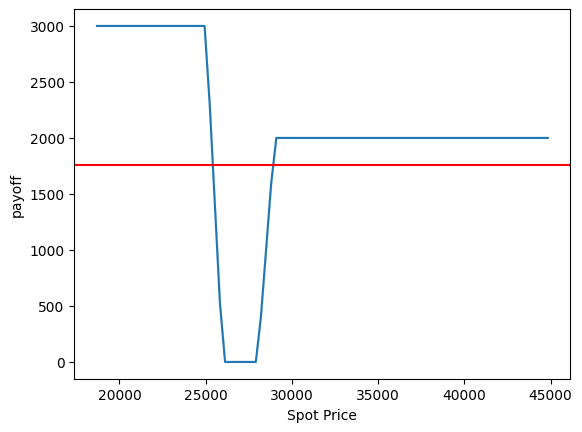

[        Price
0  770.797644,          Price
0  1184.573552,         Price
0  818.257316,         Price
0  559.054789]
net premium 1759.7327798335568
premium 8620.737798940063
Risk Reward 0.7048042943677807
probal 0.8651685393258427
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 26123.64276196015
best case, vol: 0.85 price: 18695.81411838966
min thetas -9.962484202919484
[{'type': 'P', 'strike': 25000.0, 'expiry': 0.10552773815525114, 'vol': 0.4153, 'quantity': -3, 'map': -1}, {'type': 'P', 'strike': 26000.0, 'expiry': 0.10552773815525114, 'vol': 0.4144, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 28000.0, 'expiry': 0.10552773815525114, 'vol': 0.4143, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 29000.0, 'expiry': 0.10552773815525114, 'vol': 0.41759999999999997, 'quantity': -2, 'map': -1}]


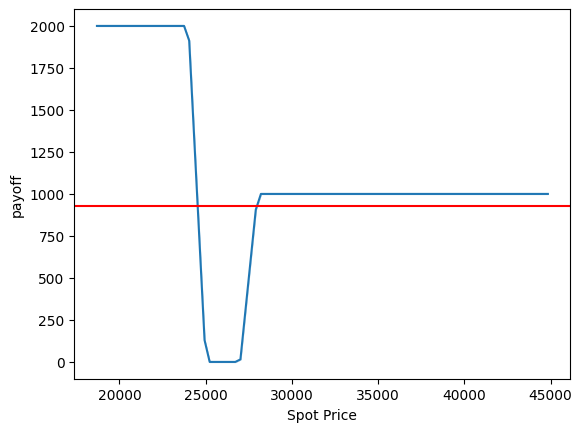

[        Price
0  516.447859,         Price
0  796.951315,          Price
0  1156.888177,         Price
0  792.238208]
net premium 925.6568798139509
premium 4575.924734291492
Risk Reward 1.16062781319357
probal 0.8651685393258427
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 25232.303324731693
best case, vol: 0.85 price: 18695.81411838966
min thetas -5.669971906243632
[{'type': 'P', 'strike': 24000.0, 'expiry': 0.10552773815525114, 'vol': 0.436, 'quantity': -2, 'map': -1}, {'type': 'P', 'strike': 25000.0, 'expiry': 0.10552773815525114, 'vol': 0.4239, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 27000.0, 'expiry': 0.10552773815525114, 'vol': 0.40740000000000004, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 28000.0, 'expiry': 0.10552773815525114, 'vol': 0.40619999999999995, 'quantity': -1, 'map': -1}]


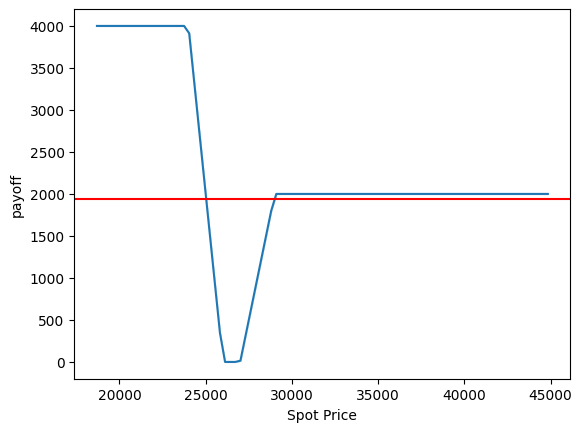

[        Price
0  516.447859,          Price
0  1184.573552,          Price
0  1156.888177,         Price
0  559.054789]
net premium 1934.084773922569
premium 5117.985788793553
Risk Reward 1.0681616720902534
probal 0.8539325842696629
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 26123.64276196015
best case, vol: 0.85 price: 18695.81411838966
min thetas -10.463154279202058
[{'type': 'P', 'strike': 24000.0, 'expiry': 0.10552773815525114, 'vol': 0.436, 'quantity': -2, 'map': -1}, {'type': 'P', 'strike': 26000.0, 'expiry': 0.10552773815525114, 'vol': 0.4144, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 27000.0, 'expiry': 0.10552773815525114, 'vol': 0.40740000000000004, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 29000.0, 'expiry': 0.10552773815525114, 'vol': 0.41759999999999997, 'quantity': -1, 'map': -1}]


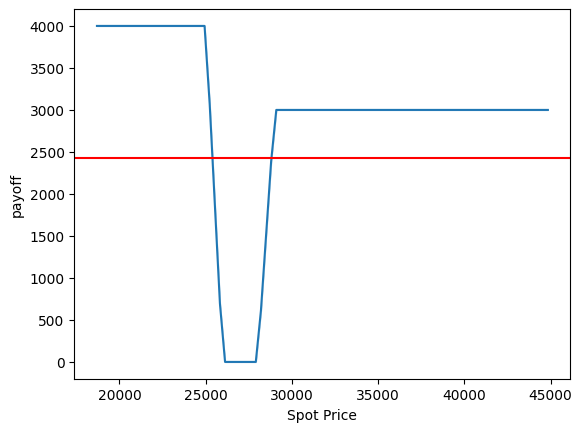

[        Price
0  770.797644,          Price
0  1184.573552,         Price
0  818.257316,         Price
0  559.054789]
net premium 2432.711215731467
premium 11953.42110022963
Risk Reward 0.6442559947656102
probal 0.8651685393258427
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 26123.64276196015
best case, vol: 0.85 price: 18695.81411838966
min thetas -13.596469040896295
[{'type': 'P', 'strike': 25000.0, 'expiry': 0.10552773815525114, 'vol': 0.4153, 'quantity': -4, 'map': -1}, {'type': 'P', 'strike': 26000.0, 'expiry': 0.10552773815525114, 'vol': 0.4144, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 28000.0, 'expiry': 0.10552773815525114, 'vol': 0.4143, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 29000.0, 'expiry': 0.10552773815525114, 'vol': 0.41759999999999997, 'quantity': -3, 'map': -1}]


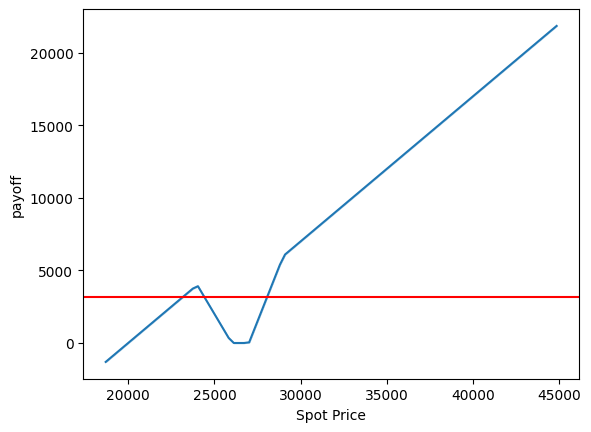

[        Price
0  516.447859,          Price
0  1184.573552,          Price
0  1156.888177,         Price
0  559.054789]
net premium 3172.3584798564984
premium 8507.264790697209
Risk Reward 4.1704964714755635
probal 0.6853932584269663
lowest possible premium -1304.1858816103413
max loss [1.41110924]
worst case, vol: 0.85 price: 18695.81411838966
best case, vol: 0.85 price: 44841.77094375779
min thetas -18.626307418504666
[{'type': 'P', 'strike': 24000.0, 'expiry': 0.10552773815525114, 'vol': 0.436, 'quantity': -3, 'map': -1}, {'type': 'P', 'strike': 26000.0, 'expiry': 0.10552773815525114, 'vol': 0.4144, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 27000.0, 'expiry': 0.10552773815525114, 'vol': 0.40740000000000004, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 29000.0, 'expiry': 0.10552773815525114, 'vol': 0.41759999999999997, 'quantity': -2, 'map': -1}]


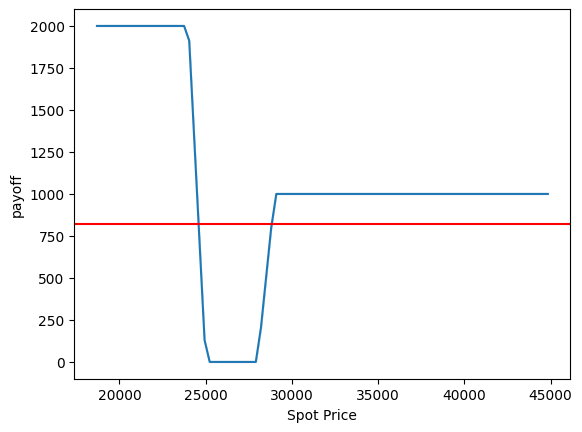

[        Price
0  516.447859,         Price
0  796.951315,         Price
0  818.257316,         Price
0  559.054789]
net premium 820.2094390522395
premium 4004.1104539232238
Risk Reward 1.4384015896123077
probal 0.8314606741573034
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 25232.303324731693
best case, vol: 0.85 price: 18695.81411838966
min thetas -6.592658445210532
[{'type': 'P', 'strike': 24000.0, 'expiry': 0.10552773815525114, 'vol': 0.436, 'quantity': -2, 'map': -1}, {'type': 'P', 'strike': 25000.0, 'expiry': 0.10552773815525114, 'vol': 0.4239, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 28000.0, 'expiry': 0.10552773815525114, 'vol': 0.4143, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 29000.0, 'expiry': 0.10552773815525114, 'vol': 0.41759999999999997, 'quantity': -1, 'map': -1}]


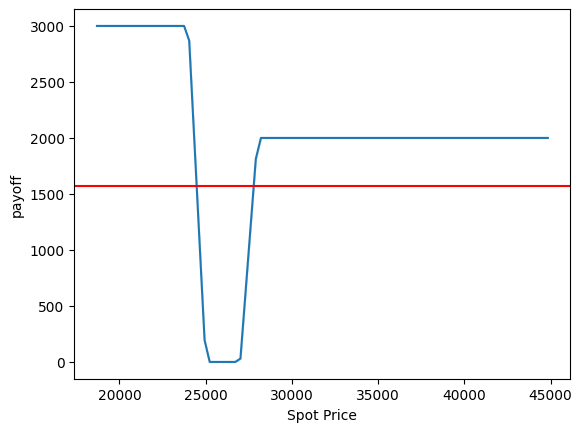

[        Price
0  516.447859,         Price
0  796.951315,          Price
0  1156.888177,         Price
0  792.238208]
net premium 1570.8103040318686
premium 7838.450294085693
Risk Reward 0.9098423229716324
probal 0.8764044943820225
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 25232.303324731693
best case, vol: 0.85 price: 18695.81411838966
min thetas -9.054371702388039
[{'type': 'P', 'strike': 24000.0, 'expiry': 0.10552773815525114, 'vol': 0.436, 'quantity': -3, 'map': -1}, {'type': 'P', 'strike': 25000.0, 'expiry': 0.10552773815525114, 'vol': 0.4239, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 27000.0, 'expiry': 0.10552773815525114, 'vol': 0.40740000000000004, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 28000.0, 'expiry': 0.10552773815525114, 'vol': 0.40619999999999995, 'quantity': -2, 'map': -1}]


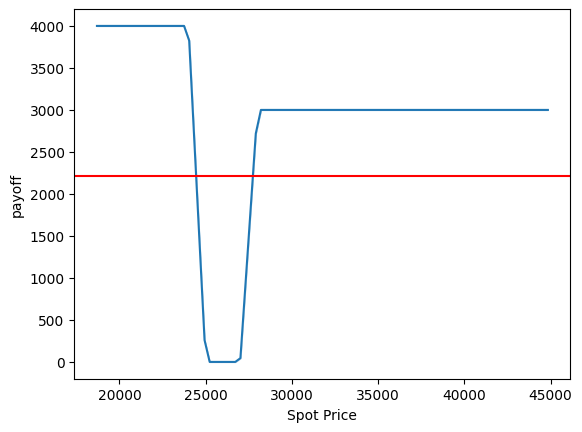

[        Price
0  516.447859,         Price
0  796.951315,          Price
0  1156.888177,         Price
0  792.238208]
net premium 2215.963728249786
premium 11100.975853879892
Risk Reward 0.8050836974480997
probal 0.8764044943820225
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 25232.303324731693
best case, vol: 0.85 price: 18695.81411838966
min thetas -12.506851207334307
[{'type': 'P', 'strike': 24000.0, 'expiry': 0.10552773815525114, 'vol': 0.436, 'quantity': -4, 'map': -1}, {'type': 'P', 'strike': 25000.0, 'expiry': 0.10552773815525114, 'vol': 0.4239, 'quantity': 4, 'map': 1}, {'type': 'C', 'strike': 27000.0, 'expiry': 0.10552773815525114, 'vol': 0.40740000000000004, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 28000.0, 'expiry': 0.10552773815525114, 'vol': 0.40619999999999995, 'quantity': -3, 'map': -1}]


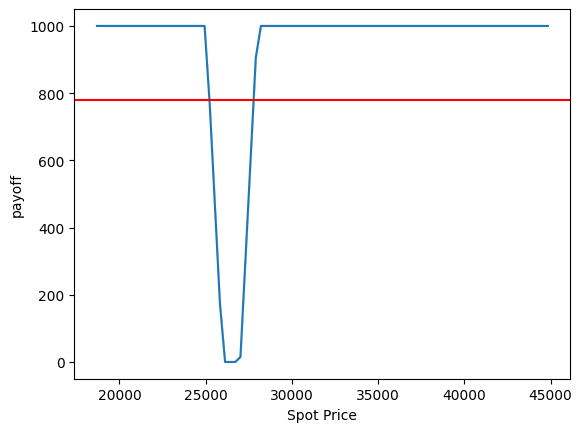

[        Price
0  770.797644,          Price
0  1184.573552,          Price
0  1156.888177,         Price
0  792.238208]
net premium 778.4258766596214
premium 3904.4975816578362
Risk Reward 0.28464383056123055
probal 0.898876404494382
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 26123.64276196015
best case, vol: 0.85 price: 18695.81411838966
min thetas -2.8203737595588336
[{'type': 'P', 'strike': 25000.0, 'expiry': 0.10552773815525114, 'vol': 0.4153, 'quantity': -1, 'map': -1}, {'type': 'P', 'strike': 26000.0, 'expiry': 0.10552773815525114, 'vol': 0.4144, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 27000.0, 'expiry': 0.10552773815525114, 'vol': 0.40740000000000004, 'quantity': 1, 'map': 1}, {'type': 'C', 'strike': 28000.0, 'expiry': 0.10552773815525114, 'vol': 0.40619999999999995, 'quantity': -1, 'map': -1}]


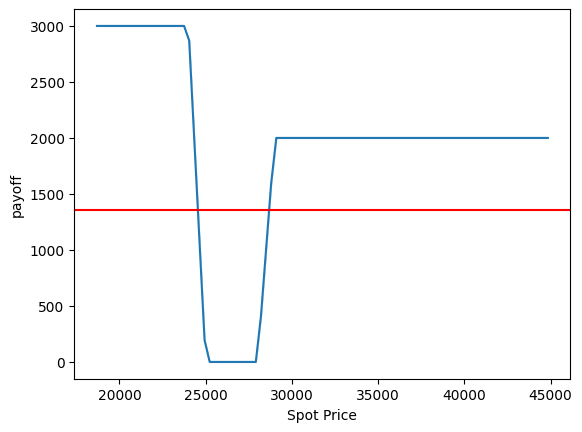

[        Price
0  516.447859,         Price
0  796.951315,         Price
0  818.257316,         Price
0  559.054789]
net premium 1359.9154225084453
premium 6694.821733349156
Risk Reward 1.206019543823042
probal 0.8426966292134831
lowest possible premium 0.0
max loss [1.]
worst case, vol: 0.85 price: 25232.303324731693
best case, vol: 0.85 price: 18695.81411838966
min thetas -10.67854115406908
[{'type': 'P', 'strike': 24000.0, 'expiry': 0.10552773815525114, 'vol': 0.436, 'quantity': -3, 'map': -1}, {'type': 'P', 'strike': 25000.0, 'expiry': 0.10552773815525114, 'vol': 0.4239, 'quantity': 3, 'map': 1}, {'type': 'C', 'strike': 28000.0, 'expiry': 0.10552773815525114, 'vol': 0.4143, 'quantity': 2, 'map': 1}, {'type': 'C', 'strike': 29000.0, 'expiry': 0.10552773815525114, 'vol': 0.41759999999999997, 'quantity': -2, 'map': -1}]


In [15]:
# bule line is the payoff curve, red line stands for net premium, yep this is for plotting
for para in temp.para[:10]:
    model.model_plot(para)